In [82]:
import sys
sys.path.append('/eos/home-i02/h/hsharma/.local/lib/python3.9/site-packages')

import deep_tabular_augmentation as dta
import warnings; warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import deep_tabular_augmentation as dta
import warnings; warnings.simplefilter('ignore')


import numpy as np
import matplotlib.pyplot as plt
import uproot ### to read, convert, inspect ROOT TTrees
import matplotlib as mpl

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable

import mlprepare as mlp
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pandas 
import uproot3 as uproot ### to read, convert, inspect ROOT TTrees
import matplotlib as mpl
import matplotlib.ticker as mtick # for 1e10 format on Axis

pathTOFile="/eos/user/h/hsharma/AMPT_Data/ampt_AuAu_1000Ev.root"
# pathTOFile="/eos/user/h/hsharma/XicBDTapply/output_BDT_sigLc_bkgXic_combined.root"
file=uproot.open(pathTOFile)
file.keys()
tree=file.get('AMPT')
df_total=tree.pandas.df()

#df_total = df_total.astype(float32)
#-----------------

df_total=df_total.rename(columns={'Event.nevent': 'evID', 'Event.impactpar':'impPar','Event.multi':'multi' })
df_total=df_total.query('evID<500 & (abs(PDG)==211 | abs(PDG)==321 | abs(PDG)==2212) & impPar>0 & impPar<3 ' )
df_total = df_total.reset_index(drop=True)
df_total.columns

Index(['evID', 'Event.nrun', 'multi', 'impPar', 'Event.NpartP', 'Event.NpartT',
       'Event.NELP', 'Event.NINP', 'Event.NELT', 'Event.NINT', 'Event.nDummy',
       'PDG', 'Px', 'Py', 'Pz', 'Mass', 'X', 'Y', 'Z', 'Time'],
      dtype='object')

array([[<Axes: title={'center': 'Px'}>, <Axes: title={'center': 'Py'}>,
        <Axes: title={'center': 'Pz'}>],
       [<Axes: title={'center': 'Mass'}>, <Axes: title={'center': 'X'}>,
        <Axes: title={'center': 'Y'}>],
       [<Axes: title={'center': 'Z'}>, <Axes: title={'center': 'Time'}>,
        <Axes: title={'center': 'PDG'}>],
       [<Axes: title={'center': 'impPar'}>,
        <Axes: title={'center': 'multi'}>, <Axes: >]], dtype=object)

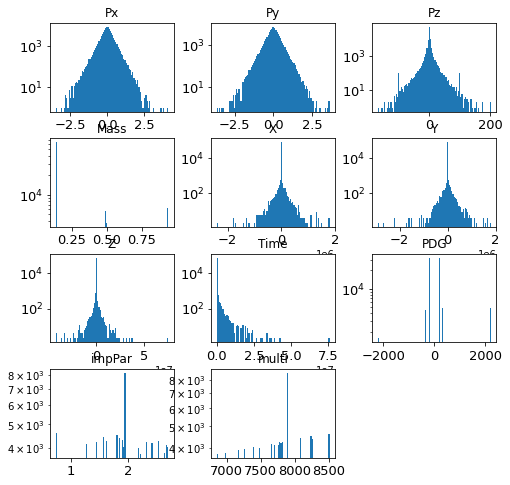

In [104]:
listOfCols=['Px','Py','Pz','Mass','X','Y','Z','Time','PDG','impPar','multi']
cutString='Px!=0 & Py!=0'
df_total.hist(column=listOfCols,figsize=(8,8),xlabelsize=13,ylabelsize=13,grid=0,bins=100,log=1)

In [105]:
list4vec=['Px', 'Py', 'Pz', 'Mass','PDG']
list4VecE=['Px', 'Py', 'Pz', 'E']

df_total=df_total[list4vec]
df_total.shape[0]


79558

array([[<Axes: title={'center': 'Px'}>, <Axes: title={'center': 'Py'}>],
       [<Axes: title={'center': 'Pz'}>, <Axes: title={'center': 'Mass'}>],
       [<Axes: title={'center': 'PDG'}>, <Axes: >]], dtype=object)

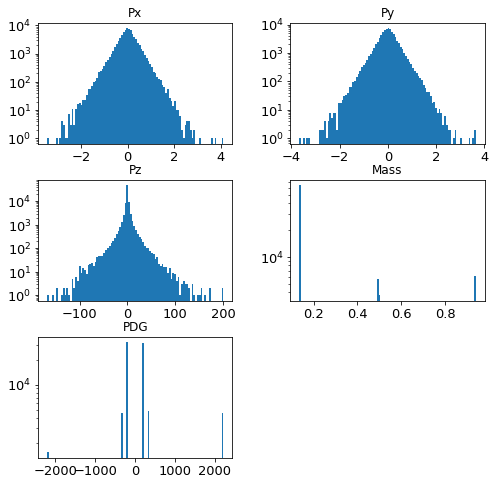

In [106]:
listOfCols=['Px','Py','Pz','Mass','X','Y','Z','Time','PDG','impPar','multi']
cutString='Px!=0 & Py!=0'
df_total=df_total.query(cutString)
df_total.hist(column=list4vec,figsize=(8,8),xlabelsize=13,ylabelsize=13,grid=0,bins=100,log=1)

In [107]:
def evalVars(df):
    # Check for non-zero denominators for xicLcRatio and xicLcRatioErr
    df['P']  = np.sqrt(df['Px']*df['Px'] + df['Py']*df['Py'] + df['Pz']*df['Pz'])
    df['E']  = np.sqrt(df['P']*df['P'] + df['Mass']*df['Mass'] )

evalVars(df_total)
# plotCols=['P','E']
# df_total.hist(plotCols,bins=100,figsize=(5,5),log=1)

array([[<Axes: title={'center': 'Pt'}>,
        <Axes: title={'center': 'InvMass'}>,
        <Axes: title={'center': 'Eta'}>],
       [<Axes: title={'center': 'Phi'}>, <Axes: title={'center': 'P'}>,
        <Axes: title={'center': 'v2Cos'}>],
       [<Axes: title={'center': 'v2Mom'}>,
        <Axes: title={'center': 'Theta'}>, <Axes: >]], dtype=object)

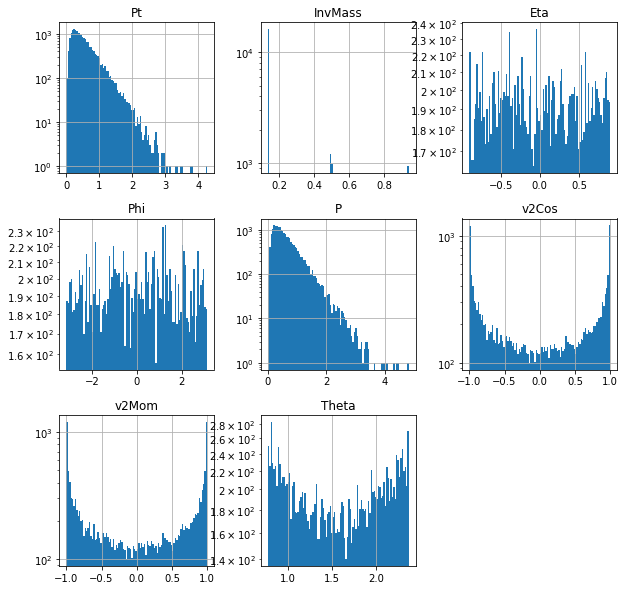

In [108]:
import ROOT
import math
# Initialize lists to store computed values
pt_list = []
mass_list = []
eta_list = []
phi_list = []
v2cos_list = []
v2mom_list = []
theta_list = []

for index, row in df_total.iterrows():
    # Create a TLorentzVector instance
    lv = ROOT.TLorentzVector()
    
    # Set the four-vector components
    lv.SetPxPyPzE(row['Px'], row['Py'], row['Pz'], row['E'])
    
    # Compute four-vector properties
    pt = lv.Pt()  # Transverse momentum
    mass = lv.M()  # Invariant mass
    eta = lv.Eta()  # Pseudorapidity
    phi = lv.Phi()  # Azimuthal angle
    theta = lv.Theta()  # Azimuthal angle
    v2cos = math.cos(2 * phi)
    v2mom = (row['Px']*row['Px'] - row['Py']*row['Py']) / (row['Px']*row['Px'] + row['Py']*row['Py'])
    
    # Append computed values to lists
    pt_list.append(pt)
    mass_list.append(mass)
    eta_list.append(eta)
    phi_list.append(phi)
    v2cos_list.append(v2cos)
    v2mom_list.append(v2mom)
    theta_list.append(theta)

    
# Add new columns to the DataFrame
df_total['Pt'] = pt_list
df_total['InvMass'] = mass_list
df_total['Eta'] = eta_list
df_total['Phi'] = phi_list
df_total['v2Cos'] = v2cos_list
df_total['v2Mom'] = v2mom_list
df_total['Theta'] = theta_list

# df_total = df_total.query('abs(v2Mom) < 0.9')

df_total = df_total.query('abs(Eta) < 0.9')

plotCols=['Pt','InvMass','Eta','Phi','P','v2Cos','v2Mom','Theta']
# plotCols=['P','P1']
df_total.hist(plotCols,bins=100,figsize=(10,10),log=1)



In [114]:
cutPt='Pt>0.5 & Pt<2 '

cutPion=' & abs(PDG)==211'
cutKaon=' & abs(PDG)==321'
cutProton='& abs(PDG)==2212'

dfPi = df_total.query(cutPt+cutPion)
dfKa = df_total.query(cutPt+cutKaon)
dfPr = df_total.query(cutPt+cutProton)

print('pion: ', dfPi.shape[0] , df_total.query(cutPt+cutPion)['v2Mom'].mean(), ' ± ',  df_total.query(cutPt+cutPion)['v2Mom'].std())
print('kaon: ', dfKa.shape[0] , df_total.query(cutPt+cutKaon)['v2Mom'].mean(), ' ± ',  df_total.query(cutPt+cutKaon)['v2Mom'].std())
print('proton: ', dfPr.shape[0] ,df_total.query(cutPt+cutProton)['v2Mom'].mean(), ' ± ',  df_total.query(cutPt+cutProton)['v2Mom'].std())

pion:  6021 0.012571010650890101  ±  0.7032778509648079
kaon:  1520 -0.010820765007052948  ±  0.7092254630630047
proton:  770 -0.033504994035805695  ±  0.7035636005328051


In [111]:
print('pion: ',df_total.query(cutPt+cutPion)['v2Cos'].mean(), ' ± ',  df_total.query(cutPt+cutPion)['v2Mom'].std())
print('kaon: ',df_total.query(cutPt+cutKaon)['v2Cos'].mean(), ' ± ',  df_total.query(cutPt+cutKaon)['v2Mom'].std())
print('proton: ',df_total.query(cutPt+cutProton)['v2Cos'].mean(), ' ± ',  df_total.query(cutPt+cutProton)['v2Mom'].std())

pion:  0.018292001976857576  ±  0.7022225810979922
kaon:  -0.012464792529312095  ±  0.705289890260738
proton:  -0.03742039788733144  ±  0.7140715321119931


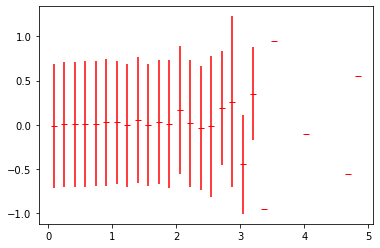

In [69]:
def compute_profile(x, y, nbin=(20,20)):
    
    # use of the 2d hist by numpy to avoid plotting
    h, xe, ye = np.histogram2d(x,y,nbin)
    
    # bin width
    xbinw = xe[1]-xe[0]

    # getting the mean and RMS values of each vertical slice of the 2D distribution
    # also the x valuse should be recomputed because of the possibility of empty slices
    x_array      = []
    x_slice_mean = []
    x_slice_rms  = []
    for i in range(xe.size-1):
        yvals = y[ (x>xe[i]) & (x<=xe[i+1]) ]
        if yvals.size>0: # do not fill the quanties for empty slices
            x_array.append(xe[i]+ xbinw/2)
            x_slice_mean.append( yvals.mean())
            x_slice_rms.append( yvals.std())
    x_array = np.array(x_array)
    x_slice_mean = np.array(x_slice_mean)
    x_slice_rms = np.array(x_slice_rms)

    return x_array, x_slice_mean, x_slice_rms

# x=Pt
# y=v2
#compute the profile
p_x, p_mean, p_rms = compute_profile(df_total['Pt'],df_total['v2Mom'],(30,30))

plt.errorbar(p_x, p_mean, p_rms,fmt='_', ecolor='r', color='r')
plt.show()

In [56]:
df_sub=df_total[list4VecE]
df_sub = df_sub.reset_index(drop=True)


In [57]:
def load_and_standardize_data(df):
    # randomly split
    X_train, X_test = train_test_split(df, test_size=0.3, random_state=42)
    # standardize values
    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train).astype(np.float32)
    X_test = scaler.transform(X_test).astype(np.float32)   
    return X_train, X_test, scaler

class DataBuilder(Dataset):
    def __init__(self, path, train=True):
        self.X_train, self.X_test, self.standardizer = load_and_standardize_data(df_sub)
        if train:
            self.x = torch.from_numpy(self.X_train)
            self.len=self.x.shape[0]
        else:
            self.x = torch.from_numpy(self.X_test)
            self.len=self.x.shape[0]
        del self.X_train
        del self.X_test 
    def __getitem__(self,index):      
        return self.x[index]
    def __len__(self):
        return self.len

In [58]:
import mlprepare as mlp

dep_var='Px'
X_train, X_test, y_train, y_test = mlp.split_df(df_sub, dep_var=dep_var, test_size=0.3, split_mode='random')

traindata_set=DataBuilder(df_sub, train=True)
testdata_set=DataBuilder(df_sub, train=False)

trainloader=DataLoader(dataset=traindata_set,batch_size=1024)
testloader=DataLoader(dataset=testdata_set,batch_size=1024)

trainloader.dataset.x.shape, testloader.dataset.x.shape

(torch.Size([2083, 4]), torch.Size([893, 4]))

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable

class Autoencoder(nn.Module):
    def __init__(self,D_in,H1=50, H2=25, Hn=12, latent_dim=3):
        
        #Encoder
        super(Autoencoder,self).__init__()
        self.linear1=nn.Linear(D_in,H1)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H1)
        
        self.linear21=nn.Linear(H1,H2)
        self.lin_bn21 = nn.BatchNorm1d(num_features=H2)

        
        self.linear2=nn.Linear(H2,Hn)
        self.lin_bn2 = nn.BatchNorm1d(num_features=Hn)
        
                
        self.linear3=nn.Linear(Hn,Hn)
        self.lin_bn3 = nn.BatchNorm1d(num_features=Hn)
        
        # ---------------------------
        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(Hn, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

        # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, Hn)
        self.fc_bn4 = nn.BatchNorm1d(Hn)
        
        # ---------------------------
        # Decoder
        self.linear4=nn.Linear(Hn,Hn)
        self.lin_bn4 = nn.BatchNorm1d(num_features=Hn)
        
        self.linear5a=nn.Linear(Hn,H2)
        self.lin_bn5a = nn.BatchNorm1d(num_features=H2)

        self.linear5b=nn.Linear(H2,H1)
        self.lin_bn5b = nn.BatchNorm1d(num_features=H1)
        
        self.linear6=nn.Linear(H1,D_in)
        self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)
        
        self.relu = nn.ReLU()
        
    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin21 = self.relu(self.lin_bn21(self.linear21(lin1)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin21)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
        
    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5a = self.relu(self.lin_bn5a(self.linear5a(lin4)))
        lin5b = self.relu(self.lin_bn5b(self.linear5b(lin5a)))
        return self.lin_bn6(self.linear6(lin5b))


        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    

class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
    
    # x_recon ist der im forward im Model erstellte recon_batch, x ist der originale x Batch, mu ist mu und logvar ist logvar 
    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD


In [60]:
D_in = traindata_set.x.shape[1] # Cols in dataset
# D_in = 4 # Cols in dataset
H1 = 50
H2 = 40
Hn = 30

model = Autoencoder(D_in, H1, H2, Hn, 10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_mse = customLoss()

In [ ]:
%%time

log_interval = 10
val_losses = []
train_losses = []
test_losses = []

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if epoch % 1 == 0:        
#         print('====> Epoch: {} Average training loss: {:.4f}'.format(
#             epoch, train_loss / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))

def test(epoch):
    with torch.no_grad():
        test_loss = 0
        for batch_idx, data in enumerate(testloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_mse(recon_batch, data, mu, logvar)
            test_loss += loss.item()
        if epoch % 1 == 0:        
#                 print('====> Epoch: {} Average test loss: {:.4f}'.format(
#                     epoch, test_loss / len(testloader.dataset)))
            test_losses.append(test_loss / len(testloader.dataset))


###---------------------------------###

epochs = 1000

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    
# Plotting losses
epochs = range(1, epochs + 1)
plt.figure(figsize=(6, 6))
plt.plot(epochs, train_losses, '-o', label='Training loss')
# If you have validation data, uncomment the line below
# plt.plot(epochs, val_losses, '-o', label='Validation loss')
plt.plot(epochs, test_losses, '-o', label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
with torch.no_grad():
    for batch_idx, data in enumerate(testloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

recon_row = recon_batch[0].cpu().numpy()
recon_row = np.append(recon_row, [1])
real_row = testloader.dataset.x[0].cpu().numpy()
real_row = np.append(real_row, [1])

# df = pd.DataFrame(np.stack((recon_row, real_row)))

#---------

sigma = torch.exp(logvar/2)
print(mu[1], sigma[1])
print(mu.mean(axis=0), sigma.mean(axis=0))

#---------
scaler = trainloader.dataset.standardizer

number_samples = df_sub.shape[0]
q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
z = q.rsample(sample_shape=torch.Size([number_samples]))

print('z.shape ', z.shape)


with torch.no_grad():
    pred = model.decode(z).cpu().numpy()

fake_data = scaler.inverse_transform(pred)
fake_data.shape

df_fake = pd.DataFrame(fake_data,columns=list4VecE)

# df_fake[['Pt']].hist(bins=50, figsize=(15,5))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

def plot_comparison(df1, df2, label1, label2, columns_to_plot, log_scale=True, x_ranges=None, xticks=None, normalize=True):
    num_cols = len(columns_to_plot)
    num_hist_rows = int(np.ceil(num_cols ** 0.5))  # Use ceiling to ensure enough rows

    # Specify the number of bins
    num_bins = 50

    # Create a grid of plots with an extra column for the heatmaps
    fig = plt.figure(figsize=(6 * (num_hist_rows + 1), 4 * num_hist_rows))
    gs = fig.add_gridspec(num_hist_rows, num_hist_rows + 1, width_ratios=[1] * num_hist_rows + [2])

    axs = np.array([[fig.add_subplot(gs[i, j]) for j in range(num_hist_rows + 1)] for i in range(num_hist_rows)])

    legend_plotted = False  # Flag to track if legend has been plotted
    
    # Plot histograms for each column from both dataframes
    for i, column in enumerate(columns_to_plot):
        row_idx = i // num_hist_rows  # Calculate the row index for the subplot
        col_idx = i % num_hist_rows   # Calculate the column index for the subplot
        x_min1 = df1[column].min()
        x_min2 = df2[column].min()
        x_max1 = df1[column].max()
        x_max2 = df2[column].max()
        x_min = min(x_min1, x_min2)
        x_max = max(x_max1, x_max2)
        x_range = (x_min, x_max)
        
        # Calculate KS statistic
        ks_stat, ks_pvalue = ks_2samp(df1[column], df2[column])
        
        axs[row_idx, col_idx].hist(df1[column], bins=num_bins, alpha=1, label=label1, density=normalize, histtype='step', range=x_range)
        axs[row_idx, col_idx].hist(df2[column], bins=num_bins, alpha=0.4, label=label2, density=normalize, color='orange', range=x_range)
        axs[row_idx, col_idx].set_xlabel('')
        axs[row_idx, col_idx].set_ylabel('')
        axs[row_idx, col_idx].set_title(column)
        
        # Add KS statistic text inside the panel
        text_x = x_min + (x_max - x_min) * 0.05  # Positioning text a bit to the right of the left edge
        text_y = axs[row_idx, col_idx].get_ylim()[1] * 0.85  # Positioning text a bit below the top edge
        axs[row_idx, col_idx].text(text_x, text_y, f'KS: {ks_stat:.2f}', fontsize=12, verticalalignment='top')
        
        if log_scale:
            axs[row_idx, col_idx].set_yscale('log')
            
        # Set x-axis range if provided
        if x_ranges and column in x_ranges:
            axs[row_idx, col_idx].set_xlim(x_ranges[column])
        
        # Set x-axis ticks if provided
        if xticks and column in xticks:
            axs[row_idx, col_idx].set_xticks(xticks[column])

        # Plot the legend only once
        if not legend_plotted:
            axs[row_idx, col_idx].legend()
            legend_plotted = True
            
    # Hide any empty subplots
    for i in range(len(columns_to_plot), num_hist_rows * num_hist_rows):
        row_idx = i // num_hist_rows
        col_idx = i % num_hist_rows
        axs[row_idx, col_idx].axis('off')

    # Calculate correlation matrices
    corr_matrix_df1 = df1[columns_to_plot].corr()
    corr_matrix_df2 = df2[columns_to_plot].corr()

    # Plot correlation matrices as heatmaps
    sns.heatmap(corr_matrix_df1, ax=axs[0, -1], annot=True, cmap='Blues', fmt=".2f", vmin=-1, vmax=1)
    axs[0, -1].set_title('MC')

    sns.heatmap(corr_matrix_df2, ax=axs[1, -1], annot=True, cmap='Blues', fmt=".2f", vmin=-1, vmax=1)
    axs[1, -1].set_title('ML model')

    # Hide the extra heatmap subplot if not needed
    for j in range(2, num_hist_rows):
        axs[j, -1].axis('off')
            
    # Adjust layout
    plt.tight_layout() 
    plt.subplots_adjust(wspace=0.4, hspace=0.4) 

    # Show the plot
    plt.show()

# Example usage
# cuts = 'fPt > 2 & fCpa < 1 & fCpaXY < 1 & fCt > 0 & fDecayLength > 0.0'

plot_comparison(df_sub, 
                df_fake,
                'AMPT',
                'ML',
                list4VecE,
                log_scale=True,
                x_ranges=None,
                xticks=None,
                normalize=True)


In [ ]:
import ROOT
import math
# Initialize lists to store computed values
pt_list = []
mass_list = []
eta_list = []
phi_list = []
v2cos_list = []
v2mom_list = []
theta_list = []

for index, row in df_total.iterrows():
    # Create a TLorentzVector instance
    lv = ROOT.TLorentzVector()
    
    # Set the four-vector components
    lv.SetPxPyPzE(row['Px'], row['Py'], row['Pz'], row['E'])
    
    # Compute four-vector properties
    pt = lv.Pt()  # Transverse momentum
    mass = lv.M()  # Invariant mass
    eta = lv.Eta()  # Pseudorapidity
    phi = lv.Phi()  # Azimuthal angle
    theta = lv.Theta()  # Azimuthal angle
    v2cos = math.cos(2 * phi)
    v2mom = (row['Px']*row['Px'] - row['Py']*row['Py']) / (row['Px']*row['Px'] + row['Py']*row['Py'])
    
    # Append computed values to lists
    pt_list.append(pt)
    mass_list.append(mass)
    eta_list.append(eta)
    phi_list.append(phi)
    v2cos_list.append(v2cos)
    v2mom_list.append(v2mom)
    theta_list.append(theta)

    
# Add new columns to the DataFrame
df_fake['Pt'] = pt_list
df_fake['InvMass'] = mass_list
df_fake['Eta'] = eta_list
df_fake['Phi'] = phi_list
df_fake['v2Cos'] = v2cos_list
df_fake['v2Mom'] = v2mom_list
df_fake['Theta'] = theta_list

# df_total = df_total.query('abs(v2Mom) < 0.9')

plotCols=['Pt','InvMass','Eta','Phi','v2Cos','v2Mom','Theta']
# plotCols=['P','P1']
df_fake.hist(plotCols,bins=100,figsize=(10,10),log=1)


In [ ]:
varsToCompare=list4VecE+['Pt','InvMass','Phi','Eta']
df_ampt=df_total[varsToCompare]
df_ml=df_fake[varsToCompare]
plot_comparison(df_ampt, 
                df_ml,
                'AMPT',
                'ML',
                varsToCompare,
                log_scale=True,
                x_ranges=None,
                xticks=None,
                normalize=True)


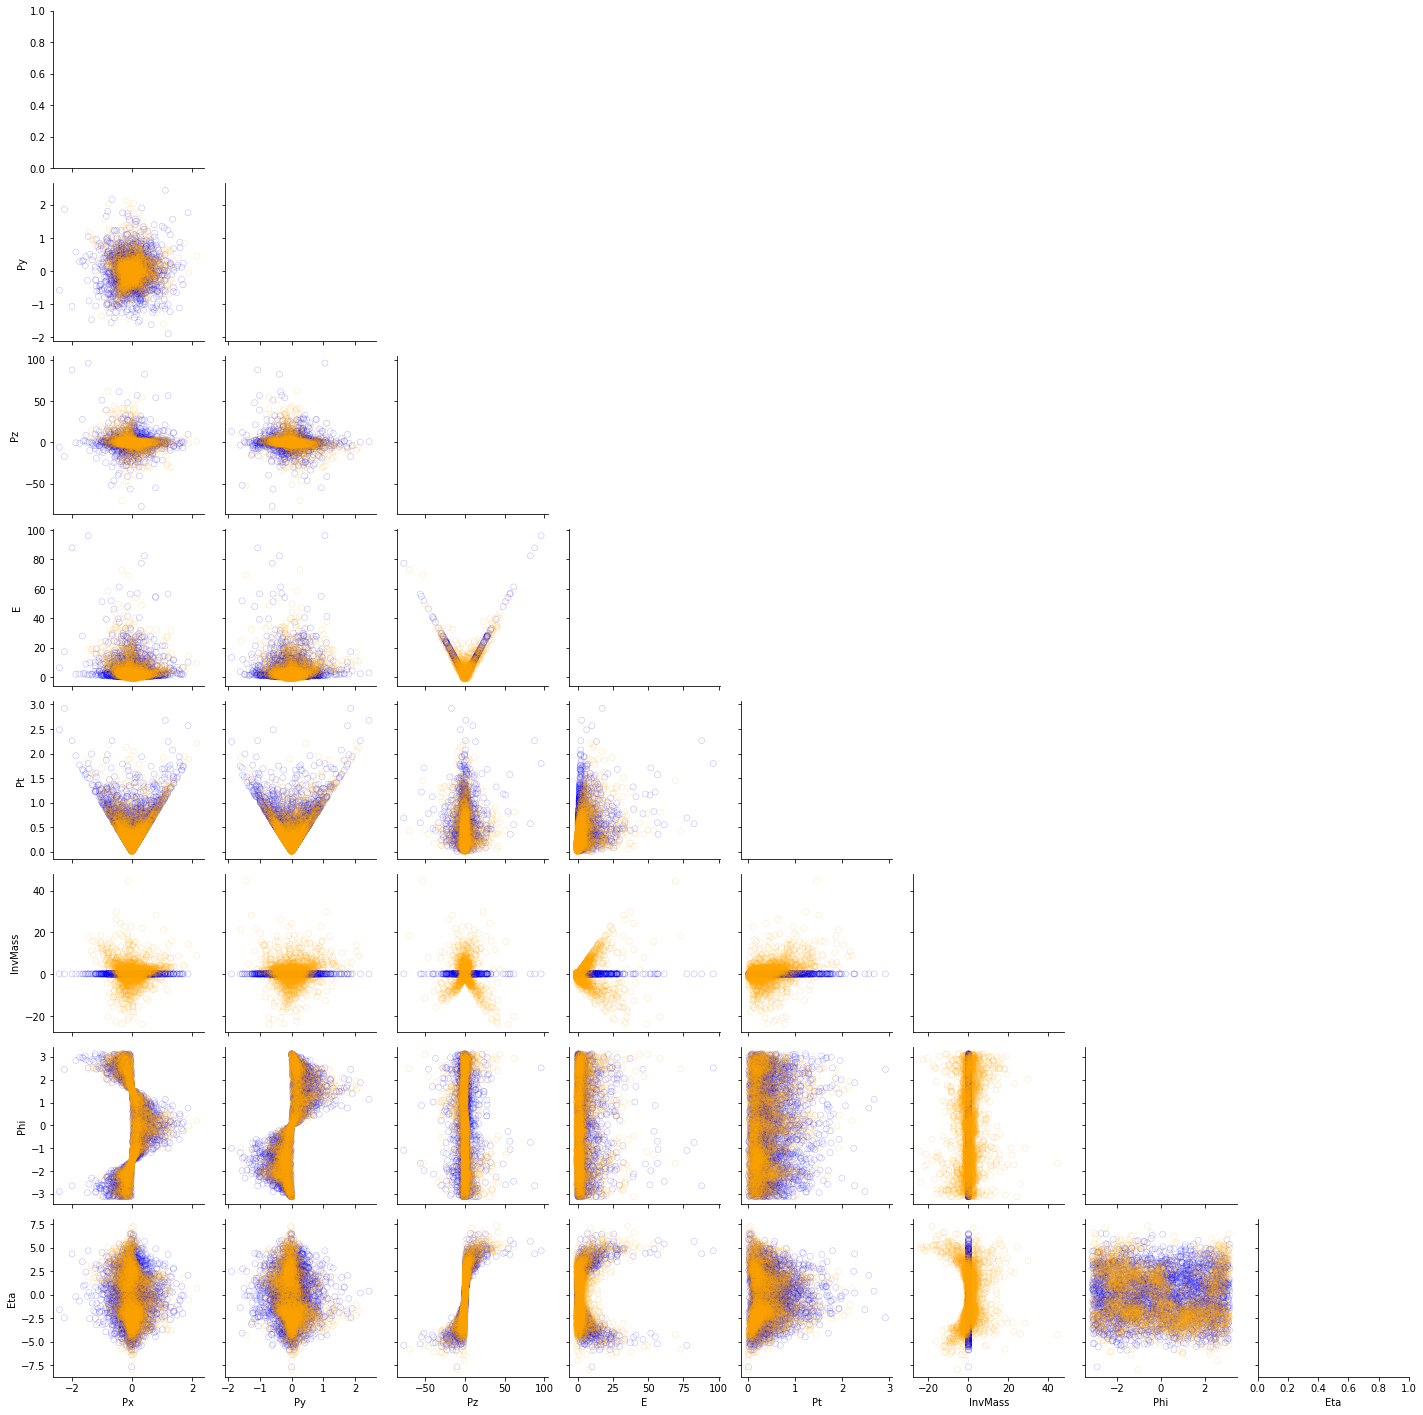

In [27]:
# Create PairGrid for df_total

g = sns.PairGrid(df_ampt, diag_sharey=False, corner=True)

# Map scatterplot for df_total
# g.map_lower(sns.scatterplot)
# g.map_lower(lambda x, y, **kwargs: sns.scatterplot(x=x, y=y, facecolors='none', edgecolor='b', alpha=0.5, **kwargs))
g.map_lower(lambda x, y, **kwargs: sns.scatterplot(x=x, y=y, facecolors='none', edgecolor='blue', alpha=0.3, **kwargs))

# g.map_diag(sns.kdeplot)


# Overlay scatterplot for df_fake
for i, j in zip(*plt.np.triu_indices_from(g.axes, 1)):
    sns.scatterplot(data=df_ml, x=df_ml.columns[i], y=df_ml.columns[j], 
                    ax=g.axes[j, i], facecolors='none', edgecolor='orange',alpha=0.3)  # You can adjust color and marker as needed

# Display the plot
plt.show()

In [28]:
print('Pi+', df.query('PDG==211').shape[0])
print('Pi-',df.query('PDG==-211').shape[0])
print('K+', df.query('PDG==321').shape[0])
print('K-',df.query('PDG==-321').shape[0])
print('p', df.query('PDG==2212').shape[0])
print('p-bar',df.query('PDG==-2212').shape[0])
print('K0s',df.query('PDG==310').shape[0])

print('all +ve',df.query('PDG>0').shape[0])
print('all -ve',df.query('PDG<0').shape[0])
df.shape[0]

NameError: name 'df' is not defined

In [106]:
dfMass=df[['evID','Px','Py','Pz','Mass','PDG','E','P']]
'''
double p_dau1 = TMath::Sqrt(p[0]*p[0] + p[1]*p[1] + p[2]*p[2]);
Double_t E_dau1_Kpos = TMath::Sqrt(p_dau1 * p_dau1 + KposMass * KposMass);
        // Calculate the invariant mass of the D0 
        Double_t energy_sum_PiK = E_dau1_pion + E_dau2_kaon;
        Double_t energy_sum_KPi = E_dau1_kaon + E_dau2_pion;    // for 2nd mass hypo

        Double_t px_sum = px1 + px2;
        Double_t py_sum = py1 + py2;
        Double_t pz_sum = pz1 + pz2;

        Double_t massPiK = energy_sum_PiK * energy_sum_PiK - px_sum * px_sum - py_sum * py_sum - pz_sum * pz_sum;
        Double_t massKPi = energy_sum_KPi * energy_sum_KPi - px_sum * px_sum - py_sum * py_sum - pz_sum * pz_sum; // // for 2nd mass hypo
    

'''
#for index, row in dfMass.iterrows():
    #print(index, row)


'\ndouble p_dau1 = TMath::Sqrt(p[0]*p[0] + p[1]*p[1] + p[2]*p[2]);\nDouble_t E_dau1_Kpos = TMath::Sqrt(p_dau1 * p_dau1 + KposMass * KposMass);\n        // Calculate the invariant mass of the D0 \n        Double_t energy_sum_PiK = E_dau1_pion + E_dau2_kaon;\n        Double_t energy_sum_KPi = E_dau1_kaon + E_dau2_pion;    // for 2nd mass hypo\n\n        Double_t px_sum = px1 + px2;\n        Double_t py_sum = py1 + py2;\n        Double_t pz_sum = pz1 + pz2;\n\n        Double_t massPiK = energy_sum_PiK * energy_sum_PiK - px_sum * px_sum - py_sum * py_sum - pz_sum * pz_sum;\n        Double_t massKPi = energy_sum_KPi * energy_sum_KPi - px_sum * px_sum - py_sum * py_sum - pz_sum * pz_sum; // // for 2nd mass hypo\n    \n\n'

<Axes: >

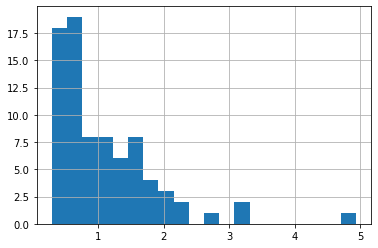

In [96]:
#df1['invMass'].hist(bins=20,range=(1.01,1.04))
df1['invMass'].hist(bins=20)